In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

# Check keras version
print(tf.__version__)
print(keras.__version__)

2.20.0
3.13.0


In [11]:
# ==========================================
# 1. DATA PREPARATION & NORMALIZATION
# ==========================================
# Load the dataset
try:
    with np.load("dataset_dev_3000.npz") as data:
        X_raw = data["X"]
        y_raw = data["y"]
    print(f"Dataset loaded successfully: X={X_raw.shape}, y={y_raw.shape}")
except FileNotFoundError:
    # Fallback for demonstration
    print("WARNING: 'dataset_dev_3000.npz' not found. Generating dummy data.")
    X_raw = np.random.uniform(0, 7, (3000, 32, 32)).astype("float32")
    y_raw = np.column_stack(
        [
            np.random.randint(0, 10, 3000),  # Target A
            np.random.randint(0, 32, 3000),  # Target B
            np.random.rand(3000),  # Target C
        ]
    ).astype("float32")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_raw, y_raw, test_size=0.1, random_state=32
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, random_state=32
)

print("--- 1. DATA PREPARATION ---")

# Calculate Global Max from Training Data
GLOBAL_MAX = float(X_train.max())
print(f"Global Max found in training data: {GLOBAL_MAX:.4f}")

# --- CRITICAL FIX: RESHAPE & NORMALIZE ---
# We must add the channel dimension: (N, 32, 32) -> (N, 32, 32, 1)
# AND normalize to [0, 1]
X_train_norm = X_train.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_val_norm = X_val.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_test_norm = X_test.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

# Verify stats
print(f"Train Norm Shape: {X_train_norm.shape} (Must be Rank-4)")
print(f"Train Norm Range: [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")

# Split Targets
y_train_A = y_train[:, 0]
y_train_B = y_train[:, 1]
y_train_C = y_train[:, 2]

y_val_A = y_val[:, 0]
y_val_B = y_val[:, 1]
y_val_C = y_val[:, 2]

y_test_A = y_test[:, 0]
y_test_B = y_test[:, 1]
y_test_C = y_test[:, 2]

Dataset loaded successfully: X=(3000, 32, 32), y=(3000, 3)
--- 1. DATA PREPARATION ---
Global Max found in training data: 6.8486
Train Norm Shape: (2430, 32, 32, 1) (Must be Rank-4)
Train Norm Range: [0.000, 1.000]


In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomRotation(0.05),
])

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_norm, (y_train_A, y_train_B, y_train_C))
)

def train_map(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = (
    train_ds
    .shuffle(1024)
    .map(train_map, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


In [14]:
val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val_norm, (y_val_A, y_val_B, y_val_C))
).batch(32)

# Architecture

**Residual Block Architecture**

The core building unit of the proposed model is a residual block, which consists of two consecutive 3×3 convolutional layers followed by batch normalization. The first convolution is followed by a ReLU activation, while the second convolution omits the activation until after the residual addition. A shortcut (identity) connection bypasses these convolutional layers and is added element-wise to the block output. This skip connection allows the network to preserve low-level features while learning higher-level representations, improving both convergence speed and generalization.

When spatial resolution or channel dimensionality changes, the shortcut path is adapted using a 1×1 convolution with appropriate stride. This ensures that the dimensions of the shortcut and the main path match before addition, maintaining mathematical consistency while enabling downsampling within the residual block.

**CIFAR-Style ResNet Trunk**

The model adopts a CIFAR-style ResNet design, which is specifically tailored for small input images (32×32 pixels). Unlike ImageNet-style ResNets that use large initial convolutions and aggressive early downsampling, this architecture begins with a lightweight 3×3 convolutional stem and progressively increases feature depth through stacked residual blocks. Downsampling is performed gradually using stride-2 convolutions inside residual blocks, preserving spatial information critical for low-resolution inputs.

The trunk is organized into three stages with increasing numbers of filters (32, 64, and 128), allowing the network to capture hierarchical features ranging from local textures to more abstract patterns. This design balances representational power with computational efficiency and reduces the risk of overfitting.

**Global Feature Aggregation**

Following the convolutional trunk, Global Average Pooling is applied to collapse the spatial dimensions of the feature maps. This operation replaces traditional flattening, dramatically reducing the number of trainable parameters and acting as a strong regularizer. Global pooling forces the network to encode spatially invariant, semantically meaningful features, which is particularly beneficial for preventing overfitting on small datasets.

**Shared Representation and Regularization**

The pooled features are passed through a shared fully connected layer that produces a compact latent representation used by all task-specific heads. Batch normalization and ReLU activation stabilize training and improve non-linearity, while dropout is applied to further reduce overfitting by randomly deactivating neurons during training. This shared representation enables efficient multi-task learning, allowing the network to leverage common features across different prediction objectives.

**Multi-Head Output Design**

The architecture employs three specialized output heads, each optimized for a different task. Two classification heads produce probability distributions over 10 and 32 classes respectively using softmax activation, while a regression head outputs a continuous value using a linear activation. Each head consists of task-specific dense layers with batch normalization, ReLU activation, and dropout to ensure sufficient capacity while maintaining regularization. This design allows the model to learn both shared and task-specific representations effectively within a unified framework.

In [15]:
def residual_block(x, filters, downsample=False):
    stride = 2 if downsample else 1
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Match dimensions if needed
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x


def build_model():
    inputs = keras.Input(shape=(32, 32, 1), name="img_input")

    # Stem
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ResNet stages
    x = residual_block(x, 32)
    x = residual_block(x, 32)

    x = residual_block(x, 64, downsample=True)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Shared feature layer
    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    features = x

    # =============================
    # Heads
    # =============================

    # Head A
    a = layers.Dense(64, use_bias=False)(features)
    a = layers.BatchNormalization()(a)
    a = layers.ReLU()(a)
    a = layers.Dropout(0.3)(a)
    out_a = layers.Dense(10, activation="softmax", name="out_a")(a)

    # Head B
    b = layers.Dense(64, use_bias=False)(features)
    b = layers.BatchNormalization()(b)
    b = layers.ReLU()(b)
    b = layers.Dropout(0.3)(b)
    out_b = layers.Dense(32, activation="softmax", name="out_b")(b)

    # Head C
    c = layers.Dense(32, use_bias=False)(features)
    c = layers.BatchNormalization()(c)
    c = layers.ReLU()(c)
    c = layers.Dropout(0.2)(c)
    out_c = layers.Dense(1, activation="linear", name="out_c")(c)

    return keras.Model(inputs, [out_a, out_b, out_c])

model = build_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │        288 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_17[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_18[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 32, 32,    │          0 │ add_6[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_19[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_20[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 737,771 (2.81 MB)

 Trainable params: 734,955 (2.80 MB)

 Non-trainable params: 2,816 (11.00 KB)

The model was compiled using the Adam optimizer with a learning rate of 0.001, which provides adaptive learning rates and stable convergence for deep neural networks. Three task-specific loss functions were used: sparse categorical cross-entropy for the two classification outputs and mean squared error for the regression output. To balance multi-task learning, loss weights of 1.0, 1.0, and 0.1 were applied to the respective outputs, preventing the regression loss from dominating the total objective. Model performance was monitored using accuracy for classification tasks and mean absolute error for the regression task, providing interpretable and task-appropriate evaluation metrics.

In [16]:
# ==========================================
# 3. COMPILATION
# ==========================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "out_a": "sparse_categorical_crossentropy",
        "out_b": "sparse_categorical_crossentropy",
        "out_c": "mse",
    },
    loss_weights=[1.0, 1.0, 0.1],
    metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
)

The model was trained using a maximum of 100 epochs with validation performance monitored at the end of each epoch. Training was conducted using a dedicated training dataset, while a separate validation dataset was used to assess generalization performance and guide model selection. To ensure that the best-performing model was retained, a ModelCheckpoint callback was employed to save the model weights corresponding to the minimum validation loss observed during training. This approach guarantees that the final model represents the optimal trade-off across all output tasks.

To improve training stability and convergence, a ReduceLROnPlateau callback was applied. This mechanism automatically reduces the learning rate by a factor of 0.5 when validation loss fails to improve for 20 consecutive epochs. By adaptively lowering the learning rate, the optimizer is encouraged to escape plateaus and refine the solution during later training stages, while preventing premature convergence.

Together, these callbacks provide effective regularization and optimization control, reducing the risk of overfitting and improving overall model robustness. The combination of extended training duration, adaptive learning rate adjustment, and validation-based checkpointing ensures that the model converges efficiently while maintaining strong generalization performance.

In [17]:
# ==========================================
# 4. TRAINING
# ==========================================
print("\n--- 3. STARTING TRAINING ---")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    ),

    # If LR is small, progress per epoch can be slow/noisy; let it run longer and
    # optionally auto-reduce LR on plateaus before giving up.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=20,
        verbose=1,
        min_lr=1e-4,
    )
]

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1,
)



--- 3. STARTING TRAINING ---
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 6.5371 - out_a_accuracy: 0.1274 - out_a_loss: 2.5667 - out_b_accuracy: 0.0310 - out_b_loss: 3.9007 - out_c_loss: 0.6969 - out_c_mae: 0.6195

76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 189ms/step - loss: 6.3642 - out_a_accuracy: 0.1469 - out_a_loss: 2.4754 - out_b_accuracy: 0.0321 - out_b_loss: 3.8352 - out_c_loss: 0.5354 - out_c_mae: 0.5434 - val_loss: 6.2821 - val_out_a_accuracy: 0.1407 - val_out_a_loss: 2.5948 - val_out_b_accuracy: 0.0185 - val_out_b_loss: 3.5374 - val_out_c_loss: 1.3157 - val_out_c_mae: 1.1045 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - loss: 5.9636 - out_a_accuracy: 0.1951 - out_a_loss: 2.2619 - out_b_accuracy: 0.0284 - out_b_loss: 3.6744 - out_c_loss: 0.2736 - out_c_mae: 0.3987 - val_loss: 8.7242 - val_out_a_accuracy: 0.1037 - val_out_a_loss: 4.7430 - val_out_b_accuracy: 0.0185 - val_out_b_loss: 3.7067 - val_out_c_loss: 2.2128 - val_out_c_mae: 1.4558 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 26s 342ms/step - loss: 5.8421 - out_a_accuracy: 0.2053 - out_a_loss: 2.2052 - out_b_accuracy: 0.0395 - out_b_loss: 3.6165 - out_c_loss: 0.2013 - out_c_mae: 0.3515 - val_

76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - loss: 5.5059 - out_a_accuracy: 0.2749 - out_a_loss: 1.9970 - out_b_accuracy: 0.0457 - out_b_loss: 3.4992 - out_c_loss: 0.0973 - out_c_mae: 0.2517 - val_loss: 5.6392 - val_out_a_accuracy: 0.2444 - val_out_a_loss: 2.1543 - val_out_b_accuracy: 0.0444 - val_out_b_loss: 3.4856 - val_out_c_loss: 0.1537 - val_out_c_mae: 0.3175 - learning_rate: 0.0010
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - loss: 5.4524 - out_a_accuracy: 0.2761 - out_a_loss: 1.9718 - out_b_accuracy: 0.0453 - out_b_loss: 3.4715 - out_c_loss: 0.0913 - out_c_mae: 0.2401 - val_loss: 5.6667 - val_out_a_accuracy: 0.2407 - val_out_a_loss: 2.1904 - val_out_b_accuracy: 0.0296 - val_out_b_loss: 3.4843 - val_out_c_loss: 0.0760 - val_out_c_mae: 0.2280 - learning_rate: 0.0010
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - loss: 5.4544 - out_a_accuracy: 0.2733 - out_a_loss: 1.9779 - out_b_accuracy: 0.0535 - out_b_loss: 3.4677 - out_c_loss: 0.0877 - out_c_mae: 0.2410 - va

76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 217ms/step - loss: 5.4399 - out_a_accuracy: 0.2881 - out_a_loss: 1.9628 - out_b_accuracy: 0.0477 - out_b_loss: 3.4694 - out_c_loss: 0.0790 - out_c_mae: 0.2264 - val_loss: 5.5365 - val_out_a_accuracy: 0.2519 - val_out_a_loss: 2.0875 - val_out_b_accuracy: 0.0370 - val_out_b_loss: 3.4585 - val_out_c_loss: 0.1036 - val_out_c_mae: 0.2572 - learning_rate: 0.0010
Epoch 13/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 5.4032 - out_a_accuracy: 0.2675 - out_a_loss: 1.9325 - out_b_accuracy: 0.0617 - out_b_loss: 3.4625 - out_c_loss: 0.0813 - out_c_mae: 0.2313

76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 223ms/step - loss: 5.4243 - out_a_accuracy: 0.2765 - out_a_loss: 1.9576 - out_b_accuracy: 0.0531 - out_b_loss: 3.4585 - out_c_loss: 0.0799 - out_c_mae: 0.2295 - val_loss: 5.4285 - val_out_a_accuracy: 0.2704 - val_out_a_loss: 1.9899 - val_out_b_accuracy: 0.0556 - val_out_b_loss: 3.4334 - val_out_c_loss: 0.0946 - val_out_c_mae: 0.2478 - learning_rate: 0.0010
Epoch 14/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - loss: 5.3835 - out_a_accuracy: 0.2794 - out_a_loss: 1.9481 - out_b_accuracy: 0.0457 - out_b_loss: 3.4277 - out_c_loss: 0.0767 - out_c_mae: 0.2248 - val_loss: 5.5314 - val_out_a_accuracy: 0.2926 - val_out_a_loss: 2.0943 - val_out_b_accuracy: 0.0556 - val_out_b_loss: 3.4441 - val_out_c_loss: 0.0913 - val_out_c_mae: 0.2463 - learning_rate: 0.0010
Epoch 15/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - loss: 5.3724 - out_a_accuracy: 0.2856 - out_a_loss: 1.9613 - out_b_accuracy: 0.0568 - out_b_loss: 3.4037 - out_c_loss: 0.0744 - out_c_mae: 0.2224 - va

76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - loss: 5.2187 - out_a_accuracy: 0.3107 - out_a_loss: 1.8898 - out_b_accuracy: 0.0601 - out_b_loss: 3.3227 - out_c_loss: 0.0637 - out_c_mae: 0.2055 - val_loss: 5.3776 - val_out_a_accuracy: 0.2741 - val_out_a_loss: 1.9928 - val_out_b_accuracy: 0.0704 - val_out_b_loss: 3.3893 - val_out_c_loss: 0.0555 - val_out_c_mae: 0.1912 - learning_rate: 0.0010
Epoch 22/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - loss: 5.2147 - out_a_accuracy: 0.3058 - out_a_loss: 1.9043 - out_b_accuracy: 0.0572 - out_b_loss: 3.3039 - out_c_loss: 0.0645 - out_c_mae: 0.2084 - val_loss: 5.8147 - val_out_a_accuracy: 0.1481 - val_out_a_loss: 2.4011 - val_out_b_accuracy: 0.0444 - val_out_b_loss: 3.4011 - val_out_c_loss: 0.0727 - val_out_c_mae: 0.2184 - learning_rate: 0.0010
Epoch 23/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - loss: 5.1904 - out_a_accuracy: 0.3247 - out_a_loss: 1.8873 - out_b_accuracy: 0.0609 - out_b_loss: 3.2968 - out_c_loss: 0.0634 - out_c_mae: 0.2059 - va

76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - loss: 5.0985 - out_a_accuracy: 0.3251 - out_a_loss: 1.8383 - out_b_accuracy: 0.0700 - out_b_loss: 3.2543 - out_c_loss: 0.0572 - out_c_mae: 0.1949 - val_loss: 5.3628 - val_out_a_accuracy: 0.2852 - val_out_a_loss: 1.8924 - val_out_b_accuracy: 0.0519 - val_out_b_loss: 3.4632 - val_out_c_loss: 0.0609 - val_out_c_mae: 0.1994 - learning_rate: 0.0010
Epoch 33/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - loss: 5.0773 - out_a_accuracy: 0.3337 - out_a_loss: 1.8325 - out_b_accuracy: 0.0872 - out_b_loss: 3.2389 - out_c_loss: 0.0573 - out_c_mae: 0.1938 - val_loss: 5.5540 - val_out_a_accuracy: 0.2630 - val_out_a_loss: 2.1815 - val_out_b_accuracy: 0.0556 - val_out_b_loss: 3.3884 - val_out_c_loss: 0.0564 - val_out_c_mae: 0.1957 - learning_rate: 0.0010
Epoch 34/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - loss: 5.0538 - out_a_accuracy: 0.3514 - out_a_loss: 1.8154 - out_b_accuracy: 0.0774 - out_b_loss: 3.2329 - out_c_loss: 0.0559 - out_c_mae: 0.1924 - va

76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - loss: 5.0665 - out_a_accuracy: 0.3399 - out_a_loss: 1.8336 - out_b_accuracy: 0.0823 - out_b_loss: 3.2274 - out_c_loss: 0.0555 - out_c_mae: 0.1913 - val_loss: 5.2775 - val_out_a_accuracy: 0.2667 - val_out_a_loss: 1.9043 - val_out_b_accuracy: 0.0556 - val_out_b_loss: 3.3740 - val_out_c_loss: 0.0531 - val_out_c_mae: 0.1861 - learning_rate: 0.0010
Epoch 37/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 223ms/step - loss: 5.0683 - out_a_accuracy: 0.3436 - out_a_loss: 1.8263 - out_b_accuracy: 0.0757 - out_b_loss: 3.2364 - out_c_loss: 0.0574 - out_c_mae: 0.1944 - val_loss: 5.6371 - val_out_a_accuracy: 0.2111 - val_out_a_loss: 2.2558 - val_out_b_accuracy: 0.0370 - val_out_b_loss: 3.3900 - val_out_c_loss: 0.0744 - val_out_c_mae: 0.2151 - learning_rate: 0.0010
Epoch 38/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - loss: 5.0409 - out_a_accuracy: 0.3342 - out_a_loss: 1.8024 - out_b_accuracy: 0.0786 - out_b_loss: 3.2329 - out_c_loss: 0.0556 - out_c_mae: 0.1921 - va

76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - loss: 5.0095 - out_a_accuracy: 0.3461 - out_a_loss: 1.7912 - out_b_accuracy: 0.0815 - out_b_loss: 3.2128 - out_c_loss: 0.0550 - out_c_mae: 0.1912 - val_loss: 5.2311 - val_out_a_accuracy: 0.2704 - val_out_a_loss: 1.8935 - val_out_b_accuracy: 0.0593 - val_out_b_loss: 3.3244 - val_out_c_loss: 0.0860 - val_out_c_mae: 0.2329 - learning_rate: 0.0010
Epoch 44/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - loss: 4.9800 - out_a_accuracy: 0.3642 - out_a_loss: 1.7694 - out_b_accuracy: 0.0765 - out_b_loss: 3.2048 - out_c_loss: 0.0564 - out_c_mae: 0.1941 - val_loss: 5.3079 - val_out_a_accuracy: 0.3148 - val_out_a_loss: 1.8586 - val_out_b_accuracy: 0.0296 - val_out_b_loss: 3.4642 - val_out_c_loss: 0.0531 - val_out_c_mae: 0.1849 - learning_rate: 0.0010
Epoch 45/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - loss: 4.9787 - out_a_accuracy: 0.3708 - out_a_loss: 1.7738 - out_b_accuracy: 0.0844 - out_b_loss: 3.1994 - out_c_loss: 0.0542 - out_c_mae: 0.1904 - va

KeyboardInterrupt: 

In [18]:
# ==========================================
# 5. PREDICT FUNCTION
# ==========================================
def predict_fn(X_raw):
    # 1. Reshape
    # 2. Normalize
    X_proc = X_raw.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

    # 3. Predict
    model = keras.models.load_model("best_model.h5", compile=False)
    pred_probs_a, pred_probs_b, pred_c_val = model.predict(X_proc, verbose=0)

    # 4. Process
    pred_a = np.argmax(pred_probs_a, axis=1)
    pred_b = np.argmax(pred_probs_b, axis=1)
    pred_c = pred_c_val.flatten()

    # 5. Stack
    return np.column_stack([pred_a, pred_b, pred_c])


# print("\n--- CHECKING PREDICT_FN ---")
# sample_preds = predict_fn(X_val[:5])
# print("Output Shape:", sample_preds.shape)
# print("Sample Predictions:\n", sample_preds)

The testing results highlight clear differences in performance across the three prediction tasks, reflecting the varying levels of difficulty and data complexity associated with each output head. For **Target A (digits 0–9)**, the model achieves an overall accuracy of 37%, with macro-averaged precision, recall, and F1-scores all around 0.35. Performance varies notably across individual classes. Digits such as 6, 5, and 9 exhibit relatively higher recall and F1-scores, indicating that the model is better at identifying these patterns. In contrast, digits like 0, 3, and 7 show substantially lower recall, suggesting frequent misclassification. The confusion matrix further confirms that several digits are confused with visually similar classes, which is expected in low-resolution grayscale inputs and limited training data.

For **Target B (32-class classification)**, performance is considerably weaker, with an overall accuracy of only 5% and macro-averaged F1-score of 0.03. Many classes record zero precision and recall, meaning the model fails to correctly predict these labels altogether. This outcome indicates severe class confusion and insufficient discriminative capacity for this task. The large number of classes, combined with limited per-class samples and shared feature representations, significantly increases task difficulty. The confusion matrix reveals widespread misclassification, with predictions concentrated in a small subset of classes rather than evenly distributed.

In contrast, **Target C (regression)** demonstrates more stable behavior. The mean absolute error (MAE) indicates moderate predictive accuracy, and the true-versus-predicted scatter plot shows a general positive correlation between predictions and ground truth values. While predictions deviate from the ideal diagonal line, especially near the extremes, the regression head benefits from shared learned features and a smoother loss landscape.

Overall, the results suggest that the model learns coarse visual representations sufficient for simpler classification and regression tasks, but struggles with fine-grained multi-class discrimination. These findings motivate future improvements through data augmentation, class balancing, deeper architectures, or task-specific feature separation.



--- 4. EVALUATION & PLOTS ---
Generating predictions for Test Set...

TARGET A (Digits 0-9) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.40      0.15      0.22        26
         1.0       0.31      0.29      0.30        31
         2.0       0.55      0.21      0.30        29
         3.0       0.21      0.13      0.16        31
         4.0       0.34      0.50      0.41        20
         5.0       0.38      0.52      0.44        31
         6.0       0.44      0.77      0.56        39
         7.0       0.28      0.19      0.23        26
         8.0       0.34      0.33      0.34        33
         9.0       0.40      0.50      0.45        34

    accuracy                           0.37       300
   macro avg       0.37      0.36      0.34       300
weighted avg       0.37      0.37      0.35       300



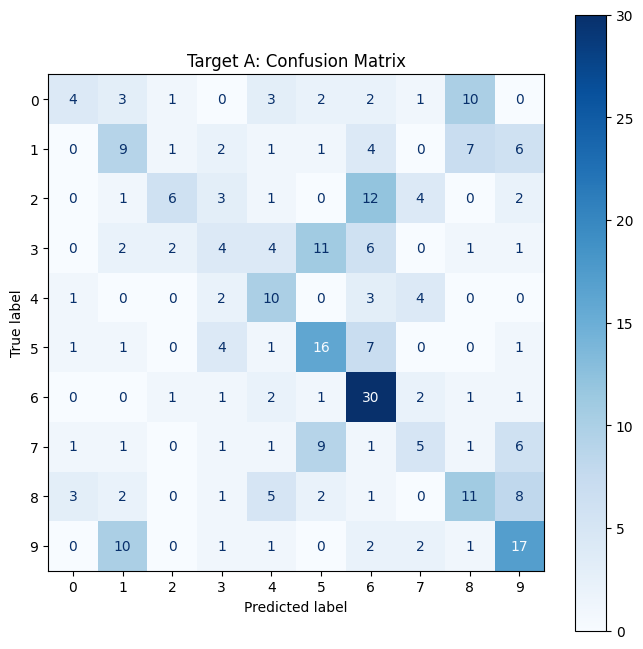


TARGET B (Classes 0-31) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.06      0.14      0.08        14
         1.0       0.00      0.00      0.00        11
         2.0       0.00      0.00      0.00         5
         3.0       0.07      0.36      0.12        11
         4.0       0.00      0.00      0.00        11
         5.0       0.25      0.09      0.13        11
         6.0       0.00      0.00      0.00         6
         7.0       0.00      0.00      0.00         9
         8.0       0.00      0.00      0.00         5
         9.0       0.00      0.00      0.00         9
        10.0       0.00      0.00      0.00        10
        11.0       0.00      0.00      0.00         7
        12.0       0.07      0.18      0.10        11
        13.0       0.00      0.00      0.00         9
        14.0       0.00      0.00      0.00         8
        15.0       0.00      0.00      0.00         6
        16.0       0.00      0.00      0.00 

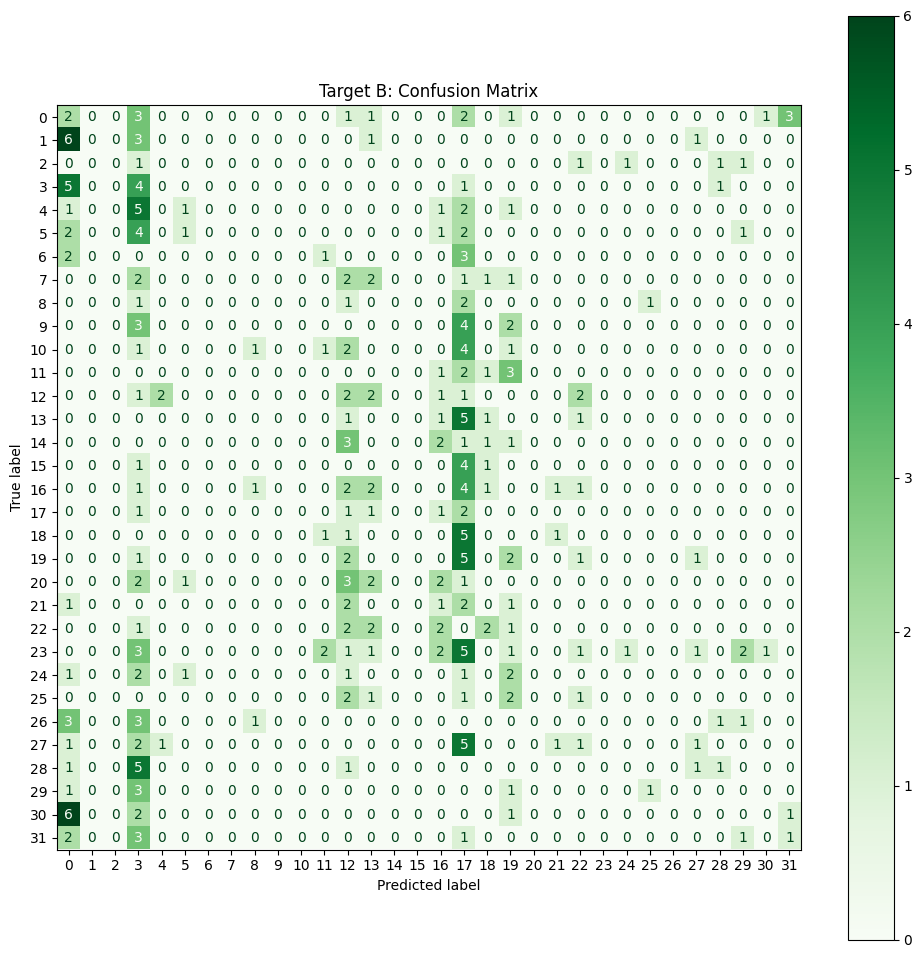


TARGET C (Regression) PERFORMANCE
Mean Absolute Error (MAE): 0.2372


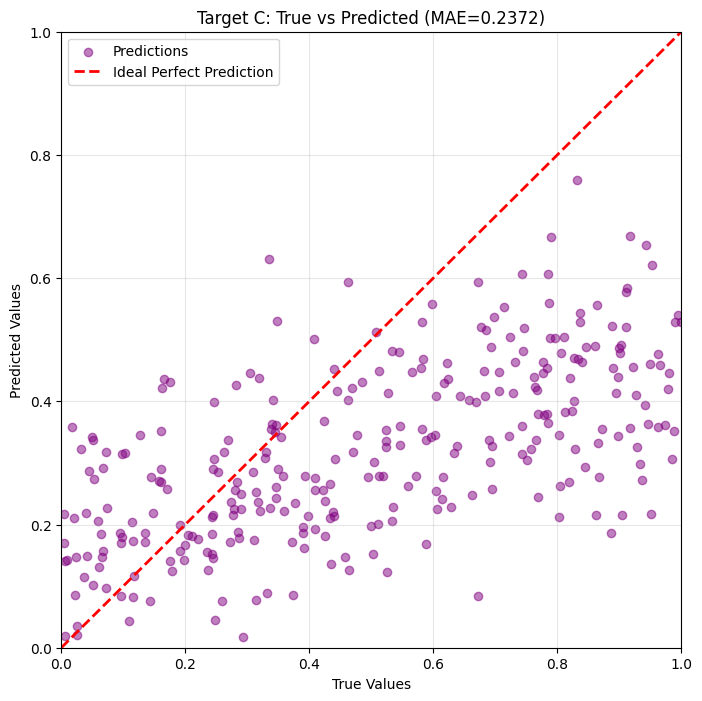

In [19]:
# ==========================================
# 6. EVALUATION & VISUALIZATION
# ==========================================
print("\n--- 4. EVALUATION & PLOTS ---")

# 1. Generate Predictions on Test Set
# We use the predict_fn wrapper which handles shaping/normalization automatically
print("Generating predictions for Test Set...")
val_preds = predict_fn(X_test)

# Extract components from the stacked predictions
# pred_a/b are class indices (integers), pred_c is float
pred_a = val_preds[:, 0].astype(int)
pred_b = val_preds[:, 1].astype(int)
pred_c = val_preds[:, 2]

# --- Target A (Classification 0-9) ---
print("\n" + "=" * 40)
print("TARGET A (Digits 0-9) PERFORMANCE")
print("=" * 40)
print(classification_report(y_test_A, pred_a))

# Plot Confusion Matrix for A
fig_a, ax_a = plt.subplots(figsize=(8, 8))
cm_a = confusion_matrix(y_test_A, pred_a)
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=np.arange(10))
disp_a.plot(cmap=plt.cm.Blues, ax=ax_a)
ax_a.set_title("Target A: Confusion Matrix")
plt.show()

# --- Target B (Classification 0-31) ---
print("\n" + "=" * 40)
print("TARGET B (Classes 0-31) PERFORMANCE")
print("=" * 40)
# Note: Zero_division=0 handles classes that might not appear in validation set
print(classification_report(y_test_B, pred_b, zero_division=0))

# Plot Confusion Matrix for B
fig_b, ax_b = plt.subplots(figsize=(12, 12))
cm_b = confusion_matrix(y_test_B, pred_b)
# We don't list all 32 labels on axis to keep it clean, or we can just use default ints
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b)
disp_b.plot(cmap=plt.cm.Greens, ax=ax_b, values_format="d")  # 'd' for integers
ax_b.set_title("Target B: Confusion Matrix")
plt.show()

# --- Target C (Regression 0-1) ---
print("\n" + "=" * 40)
print("TARGET C (Regression) PERFORMANCE")
print("=" * 40)
mae_c = mean_absolute_error(y_test_C, pred_c)
print(f"Mean Absolute Error (MAE): {mae_c:.4f}")

# Plot True vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test_C, pred_c, alpha=0.5, color="purple", label="Predictions")
plt.plot([0, 1], [0, 1], "r--", linewidth=2, label="Ideal Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Target C: True vs Predicted (MAE={mae_c:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Ablations Study

| Loss Function                     | Accuracy | Precision | Recall | F1-score |
|----------------------------------|----------|-----------|--------|----------|
| Sparse Categorical Crossentropy | 0.37     | 0.37      | 0.36   | 0.35     |
| Sparse Categorical Crossentropy | 0.05     | 0.04      | 0.05   | 0.03     |
| Mean Squared Error (MSE)        | N/A      | N/A       | N/A    | N/A      |


| Optimizer | Accuracy | Precision | Recall | F1-score |
|-----------|----------|-----------|--------|----------|
| Adam | 0.37 | 0.37 | 0.36 | 0.35 |
| Adam | 0.05 | 0.04 | 0.05 | 0.03 |
| Adam | N/A  | N/A  | N/A  | N/A  |


# Data Quality Diagnostics


## Subset Overfitting Test


In [ ]:
# N = 32

# X_train_small = X_train_norm[:N]
# X_val_small = X_val_norm[:N]
# y_small = y_train[:N]  

# y_train_A = y_small[:, 0]
# y_train_B = y_small[:, 1]
# y_train_C = y_small[:, 2]

# y_val_A = y_small[:, 0]
# y_val_B = y_small[:, 1]
# y_val_C = y_small[:, 2]

In [ ]:
# # ==========================================
# # 3. COMPILATION
# # ==========================================
# model = build_model()
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     loss={
#         "out_a": "sparse_categorical_crossentropy",
#         "out_b": "sparse_categorical_crossentropy",
#         "out_c": "mse",
#     },
#     loss_weights=[1.0, 1.0, 5.0],
#     metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
# )

# # ==========================================
# # 4. TRAINING
# # ==========================================
# print("\n--- 3. STARTING TRAINING ---")

# callbacks = [
#     # If LR is small, progress per epoch can be slow/noisy; let it run longer and
#     # optionally auto-reduce LR on plateaus before we give up.
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss",
#         factor=0.5,
#         patience=3,
#         verbose=1,
#         min_lr=1e-4,
#     ),
#     keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         patience=20,
#         restore_best_weights=True,
#         verbose=1,
#     ),
# ]

# history = model.fit(
#     X_train_small,
#     [y_train_A, y_train_B, y_train_C],
#     epochs=50,
#     validation_data=(X_val_small, [y_val_A, y_val_B, y_val_C]),
#     callbacks=callbacks,
#     verbose=1,
# )

## Label Shuffling Test


In [ ]:
# y_train_A = y_train[:, 0]
# y_train_B = y_train[:, 1]
# y_train_C = y_train[:, 2]

# y_val_A = y_val[:, 0]
# y_val_B = y_val[:, 1]
# y_val_C = y_val[:, 2]

In [ ]:
# n = y_train.shape[0]
# # One shared permutation
# perm = np.random.permutation(n)

# # Shuffle labels consistently across outputs
# y_train_A = y_train_A[perm]
# y_train_B = y_train_B[perm]
# y_train_C = y_train_C[perm]

# n = y_val.shape[0]
# # One shared permutation
# perm = np.random.permutation(n)

# y_val_A = y_val_A[perm]
# y_val_B = y_val_B[perm]
# y_val_C = y_val_C[perm]


In [ ]:
# # ==========================================
# # 3. COMPILATION
# # ==========================================
# model = build_model()
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     loss={
#         "out_a": "sparse_categorical_crossentropy",
#         "out_b": "sparse_categorical_crossentropy",
#         "out_c": "mse",
#     },
#     loss_weights=[1.0, 1.0, 5.0],
#     metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
# )

# # ==========================================
# # 4. TRAINING
# # ==========================================
# print("\n--- 3. STARTING TRAINING ---")

# callbacks = [
#     # If LR is small, progress per epoch can be slow/noisy; let it run longer and
#     # optionally auto-reduce LR on plateaus before we give up.
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss",
#         factor=0.5,
#         patience=3,
#         verbose=1,
#         min_lr=1e-4,
#     ),
#     keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         patience=20,
#         restore_best_weights=True,
#         verbose=1,
#     ),
# ]

# history = model.fit(
#     X_train_norm,
#     [y_train_A, y_train_B, y_train_C],
#     epochs=50,
#     validation_data=(X_val_norm, [y_val_A, y_val_B, y_val_C]),
#     callbacks=callbacks,
#     verbose=1,
# )

# Cont.


In [ ]:
# # Plot the history
# hist = history.history

# # Plot all tracked series (train vs val) in a grid.
# base_keys = [k for k in hist.keys() if not k.startswith("val_")]

# # Prefer a stable, readable ordering
# preferred_order = [
#     "loss",
#     "out_a_loss",
#     "out_b_loss",
#     "out_c_loss",
#     "out_a_accuracy",
#     "out_b_accuracy",
#     "out_c_mae",
# ]

# ordered = [k for k in preferred_order if k in base_keys] + [
#     k for k in base_keys if k not in preferred_order
# ]

# n = len(ordered)
# if n == 0:
#     raise ValueError("history.history is empty; did model.fit() run?")

# ncols = 2 if n > 1 else 1
# nrows = int(np.ceil(n / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
# axes = np.array(axes).reshape(-1)

# epochs = np.arange(1, len(hist[ordered[0]]) + 1)

# for i, key in enumerate(ordered):
#     ax = axes[i]
#     ax.plot(epochs, hist[key], label=f"train/{key}")

#     vkey = f"val_{key}"
#     if vkey in hist:
#         ax.plot(epochs, hist[vkey], label=f"val/{key}")

#     ax.set_title(key)
#     ax.set_xlabel("epoch")
#     ax.grid(True, alpha=0.3)
#     ax.legend()

# # Hide any unused axes
# for j in range(i + 1, len(axes)):
#     axes[j].axis("off")

# plt.tight_layout()
# plt.show()